In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns

# **SSC0957 - Prática em Ciência de Dados II**
---

### **Alunos:**
> #### Arthur Santorum Lorenzetto - 12559465
> #### André Guarnier De Mitri    - 11395579
> #### Rui Emanuel Lima Vieira    - 11819182

### **Professor:** Alexandre Claudio Botazzo Delbem
---

In [18]:
obitos_transp = pd.read_parquet('Dados/obitos_transparencia.parquet', engine='pyarrow')
obitos_transp.head()

,uf,tipo_doenca,local_obito,faixa_etaria,sexo,total,Ano
0,AC,OUTRAS,DOMICILIO,< 9,F,7,2019
1,AC,OUTRAS,DOMICILIO,< 9,M,15,2019
2,AC,OUTRAS,HOSPITAL,< 9,F,30,2019
3,AC,OUTRAS,HOSPITAL,< 9,M,55,2019
4,AC,OUTRAS,IGNORADO,< 9,M,1,2019


In [19]:
obitos_raca_cor = pd.read_parquet('Dados/obitos_raca_cor.parquet', engine='pyarrow')
obitos_raca_cor.head()

,codigo_ibge,nome_munic,nome_drs,obito,raca_cor,idade,cs_sexo,asma,cardiopatia,diabetes,doenca_hematologica,doenca_hepatica,doenca_neurologica,doenca_renal,imunodepressao,obesidade,pneumopatia,puerpera,sindrome_de_down
0,3500303.0,Aguaí,São João da Boa Vista,False,None,41.0,feminino,NaN,9.0,9.0,NaN,NaN,NaN,9.0,9.0,NaN,NaN,NaN,NaN
1,3555000.0,Tupã,Marília,False,PARDA,31.0,feminino,NaN,9.0,9.0,NaN,NaN,NaN,9.0,9.0,NaN,NaN,NaN,NaN
2,3534401.0,Osasco,Grande SP Oeste,False,PARDA,32.0,feminino,NaN,9.0,9.0,NaN,NaN,NaN,9.0,9.0,NaN,NaN,NaN,NaN
3,3548708.0,São Bernardo do Campo,Grande SP Sudeste,False,PARDA,41.0,feminino,NaN,9.0,9.0,NaN,NaN,NaN,9.0,9.0,NaN,NaN,NaN,NaN
4,3557006.0,Votorantim,Sorocaba,False,BRANCA,44.0,feminino,NaN,9.0,9.0,NaN,NaN,NaN,9.0,9.0,NaN,NaN,NaN,NaN


# Bibliotecas e tratamento de dados

In [20]:
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from imblearn.under_sampling import RandomUnderSampler

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Modelos de Classificação

In [21]:
def dataset_scaler(df: pd.DataFrame, one_hot: bool = False, clean_nan: bool = False, ):
  df1 = df.copy(deep=True)
  if one_hot:
    df1 = pd.get_dummies(df1, columns = list_categorical_columns)
  else:
    le = LabelEncoder()
    for c in list_categorical_columns:
      df1[c] = le.fit_transform(df1[c])
    
  if clean_nan:
    imputer = SimpleImputer()
    df1[list_numerical_columns] = imputer.fit_transform(df1[list_numerical_columns])
#     y_imputer = SimpleImputer(missing_values=np.nan)
#     y =  y_imputer.fit_transform(y)
  scaler = RobustScaler()
  df1[list_numerical_columns] = scaler.fit_transform(df1[list_numerical_columns])

  return df1

## Logistic Regression

In [6]:
df = obitos_raca_cor.copy()
df.drop(columns=['cs_sexo', 'nome_munic'], inplace=True)
list_categorical_columns = list(df.select_dtypes(include='object').columns)
list_numerical_columns = list(df.select_dtypes(include='number').columns)
df = dataset_scaler(df, clean_nan=True)
y = df['obito']
X = df.drop(columns=['obito'])
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 1/3, random_state=42)
rus = RandomUnderSampler(random_state=42, sampling_strategy = 0.5)
x_train, y_train = rus.fit_resample(x_train, y_train)

Melhores parametros : {'C': 0.1, 'random_state': 42}
Melhor Score        : 0.8709606966565959
Melhor acurácia encontrada:  0.9193519418113069
Matrix de Confusão : 



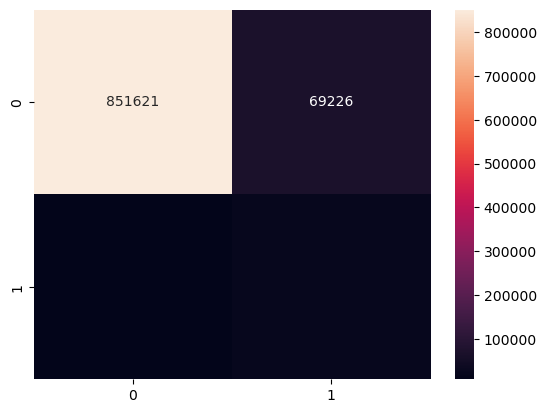

In [7]:
# Modelo
mdl = LogisticRegression(max_iter=1000)

# Parametros
parameters = {
    'C' :  np.arange(0.1, 2, 0.3),
    'random_state' : [42]
}

# Buscando melhor hyperparametro
searcher = GridSearchCV(mdl, parameters)
searcher.fit(x_train, y_train)

# Scores
print("Melhores parametros :", searcher.best_params_)
print("Melhor Score        :", searcher.best_score_)

# Predizendo os valores
y_pred = searcher.predict(x_test)

# printing the test accuracy
print("Melhor acurácia encontrada: ", accuracy_score(y_test, y_pred))

# Matrix Confusao
cm = confusion_matrix(y_test, y_pred)
print("Matrix de Confusão : \n")
sns.heatmap(cm,annot=True,fmt="d")
plt.show()

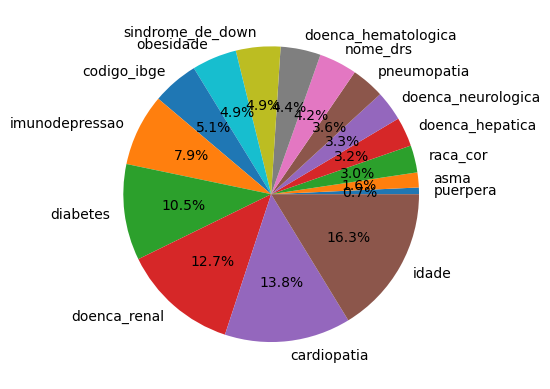

In [8]:
from sklearn.inspection import permutation_importance

# Pegando o melhor modelo do Searcher
model = searcher.best_estimator_
result = permutation_importance(model, x_train, y_train, n_repeats=10, n_jobs=-1)
sorted = result.importances_std.argsort()
fig, ax = plt.subplots()
ax.pie(result.importances_std[sorted], labels=x_train.columns[sorted], autopct='%1.1f%%')
plt.show()

## Random Forest

In [9]:
df = obitos_raca_cor.copy()
df.drop(columns=['cs_sexo', 'nome_munic'], inplace=True)
list_categorical_columns = list(df.select_dtypes(include='object').columns)
list_numerical_columns = list(df.select_dtypes(include='number').columns)
df = dataset_scaler(df, clean_nan=True)
y = df['obito']
X = df.drop(columns=['obito'])
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 1/3, random_state=42)
rus = RandomUnderSampler(random_state=42, sampling_strategy = 0.5)
x_train, y_train = rus.fit_resample(x_train, y_train)

Melhores parametros : {'criterion': 'gini', 'max_depth': 6, 'n_estimators': 200, 'random_state': 42}
Melhor Score        : 0.9437133369092635
Melhor acurácia encontrada:  0.9164572118793163
Matrix de Confusão : 



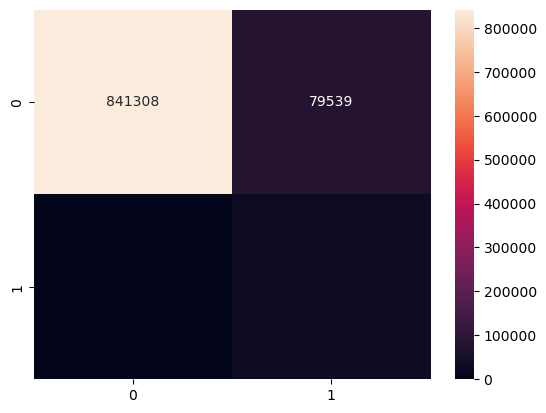

In [10]:
# Modelo
mdl = RandomForestClassifier()

# Parametros
parameters = { 
    'n_estimators': np.arange(100,400,100),
    'max_depth' :  np.arange(3,9,3),
    'criterion' :['gini', 'entropy'],
    'random_state' : [42]
}

# Buscando melhor hyperparametro
searcher = GridSearchCV(mdl, parameters)
searcher.fit(x_train, y_train)

# Scores
print("Melhores parametros :", searcher.best_params_)
print("Melhor Score        :", searcher.best_score_)

# Predizendo os valores
y_pred = searcher.predict(x_test)

# printing the test accuracy
print("Melhor acurácia encontrada: ", accuracy_score(y_test, y_pred))

# Matrix Confusao
cm = confusion_matrix(y_test, y_pred)
print("Matrix de Confusão : \n")
sns.heatmap(cm,annot=True,fmt="d")
plt.show()

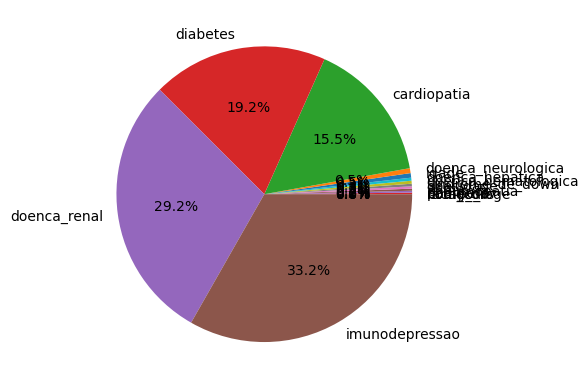

In [11]:
from sklearn.inspection import permutation_importance

# Pegando o melhor modelo do Searcher
model = searcher.best_estimator_
result = permutation_importance(model, x_train, y_train, n_repeats=10, n_jobs=-1)
sorted = result.importances_std.argsort()
fig, ax = plt.subplots()
ax.pie(result.importances_std[sorted], labels=x_train.columns[sorted], autopct='%1.1f%%')
plt.show()

## SVC

In [12]:
df = obitos_raca_cor.copy()
df.drop(columns=['cs_sexo', 'nome_munic'], inplace=True)
list_categorical_columns = list(df.select_dtypes(include='object').columns)
list_numerical_columns = list(df.select_dtypes(include='number').columns)
df = dataset_scaler(df, clean_nan=True)
y = df['obito']
X = df.drop(columns=['obito'])
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 1/3, random_state=42)
rus = RandomUnderSampler(random_state=42, sampling_strategy = 0.5)
x_train, y_train = rus.fit_resample(x_train, y_train)

In [13]:
# Modelo
mdl = SVC()

# Parametros
parameters = {"C":np.arange(1,12,4),
              'gamma':[0.00001,0.01,1],
              'random_state' : [42]}

# Buscando melhor hyperparametro
searcher = GridSearchCV(mdl, parameters)
searcher.fit(x_train, y_train)

# Scores
print("Melhores parametros :", searcher.best_params_)
print("Melhor Score        :", searcher.best_score_)

# Predizendo os valores
y_pred = searcher.predict(x_test)

# printing the test accuracy
print("Melhor acurácia encontrada: ", accuracy_score(y_test, y_pred))

# Matrix Confusao
cm = confusion_matrix(y_test, y_pred)
print("Matrix de Confusão : \n")
sns.heatmap(cm,annot=True,fmt="d")
plt.show()

KeyboardInterrupt: 

In [14]:
from sklearn.inspection import permutation_importance

# Pegando o melhor modelo do Searcher
model = searcher.best_estimator_
result = permutation_importance(model, x_train, y_train, n_repeats=10, n_jobs=-1)
sorted = result.importances_std.argsort()
fig, ax = plt.subplots()
ax.pie(result.importances_std[sorted], labels=x_train.columns[sorted], autopct='%1.1f%%')
plt.show()

AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

## Decision Tree

In [22]:
df = obitos_raca_cor.copy()
df.drop(columns=['cs_sexo', 'nome_munic'], inplace=True)
list_categorical_columns = list(df.select_dtypes(include='object').columns)
list_numerical_columns = list(df.select_dtypes(include='number').columns)
df = dataset_scaler(df, clean_nan=True)
y = df['obito']
X = df.drop(columns=['obito'])
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 1/3, random_state=42)
rus = RandomUnderSampler(random_state=42, sampling_strategy = 0.5)
x_train, y_train = rus.fit_resample(x_train, y_train)

Melhores parametros : {'criterion': 'entropy', 'max_depth': 11, 'random_state': 42}
Melhor Score        : 0.9439209570177358
Melhor acurácia encontrada:  0.923906204868314
Matrix de Confusão : 



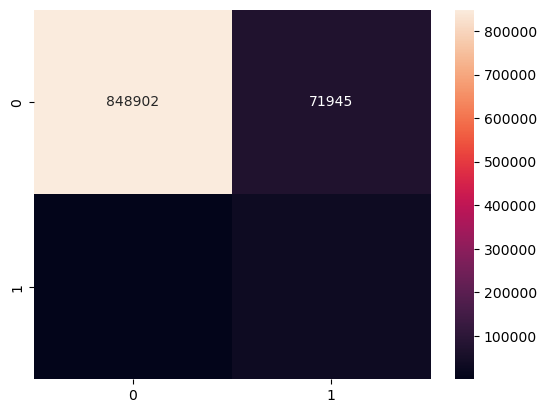

In [23]:
# Modelo
mdl = DecisionTreeClassifier()

# Parametros
parameters = {'criterion':['gini','entropy'],
              'max_depth': np.arange(1, 20, 5),
              'random_state' : [42]}

# Buscando melhor hyperparametro
searcher = GridSearchCV(mdl, parameters)
searcher.fit(x_train, y_train)

# Scores
print("Melhores parametros :", searcher.best_params_)
print("Melhor Score        :", searcher.best_score_)

# Predizendo os valores
y_pred = searcher.predict(x_test)

# printing the test accuracy
print("Melhor acurácia encontrada: ", accuracy_score(y_test, y_pred))

# Matrix Confusao
cm = confusion_matrix(y_test, y_pred)
print("Matrix de Confusão : \n")
sns.heatmap(cm,annot=True,fmt="d")
plt.show()

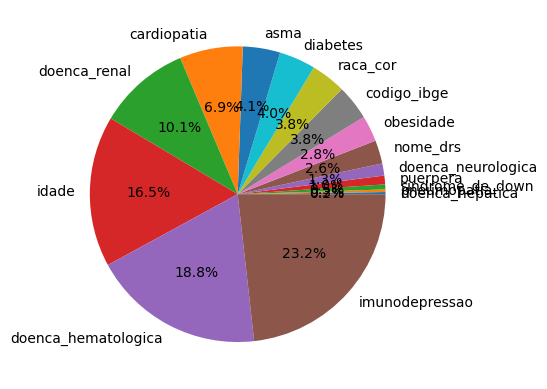

In [24]:
from sklearn.inspection import permutation_importance

# Pegando o melhor modelo do Searcher
model = searcher.best_estimator_
result = permutation_importance(model, x_train, y_train, n_repeats=10, n_jobs=-1)
sorted = result.importances_std.argsort()
fig, ax = plt.subplots()
ax.pie(result.importances_std[sorted], labels=x_train.columns[sorted], autopct='%1.1f%%')
plt.show()

## KNN Classifier

In [25]:
df = obitos_raca_cor.copy()
df.drop(columns=['cs_sexo', 'nome_munic'], inplace=True)
list_categorical_columns = list(df.select_dtypes(include='object').columns)
list_numerical_columns = list(df.select_dtypes(include='number').columns)
df = dataset_scaler(df, clean_nan=True)
y = df['obito']
X = df.drop(columns=['obito'])
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 1/3, random_state=42)
rus = RandomUnderSampler(random_state=42, sampling_strategy = 0.5)
x_train, y_train = rus.fit_resample(x_train, y_train)

In [ ]:
# Modelo
mdl = KNeighborsClassifier(metric='minkowski')

# Parametros
parameters = {'n_neighbors':np.arange(1,30,5),
              'p': [1, 5, 10]}

# Buscando melhor hyperparametro
searcher = GridSearchCV(mdl, parameters)
searcher.fit(x_train, y_train)

# Scores
print("Melhores parametros :", searcher.best_params_)
print("Melhor Score        :", searcher.best_score_)

# Predizendo os valores
y_pred = searcher.predict(x_test)

# Melhor acuracia
print("Melhor acurácia encontrada: ", accuracy_score(y_test, y_pred))

# Matrix Confusao
cm = confusion_matrix(y_test, y_pred)
print("Matrix de Confusão : \n")
sns.heatmap(cm,annot=True,fmt="d")
plt.show()

In [ ]:
from sklearn.inspection import permutation_importance

# Pegando o melhor modelo do Searcher
model = searcher.best_estimator_
result = permutation_importance(model, x_train, y_train, n_repeats=10, n_jobs=-1)
sorted = result.importances_std.argsort()
fig, ax = plt.subplots()
ax.pie(result.importances_std[sorted], labels=x_train.columns[sorted], autopct='%1.1f%%')
plt.show()

## GaussianNB

In [ ]:
df = obitos_raca_cor.copy()
df.drop(columns=['cs_sexo', 'nome_munic'], inplace=True)
list_categorical_columns = list(df.select_dtypes(include='object').columns)
list_numerical_columns = list(df.select_dtypes(include='number').columns)
df = dataset_scaler(df, clean_nan=True)
y = df['obito']
X = df.drop(columns=['obito'])
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 1/3, random_state=42)
rus = RandomUnderSampler(random_state=42, sampling_strategy = 0.5)
x_train, y_train = rus.fit_resample(x_train, y_train)

In [ ]:
# Modelo
mdl = GaussianNB()

# Parametros
parameters = {'var_smoothing': np.logspace(0,-9, num=100)}

# Buscando melhor hyperparametro
searcher = GridSearchCV(estimator=mdl, 
                 param_grid=parameters, 
                 scoring='accuracy') 
searcher.fit(x_train, y_train)

# Scores
print("Melhores parametros :", searcher.best_params_)
print("Melhor Score        :", searcher.best_score_)

# Predizendo os valores
y_pred = searcher.predict(x_test)

# printing the test accuracy
print("Melhor acurácia encontrada: ", accuracy_score(y_test, y_pred))

# Matrix Confusao
cm = confusion_matrix(y_test, y_pred)
print("Matrix de Confusão : \n")
sns.heatmap(cm,annot=True,fmt="d")
plt.show()

In [ ]:
from sklearn.inspection import permutation_importance

# Pegando o melhor modelo do Searcher
model = searcher.best_estimator_
result = permutation_importance(model, x_train, y_train, n_repeats=10, n_jobs=-1)
sorted = result.importances_std.argsort()
fig, ax = plt.subplots()
ax.pie(result.importances_std[sorted], labels=x_train.columns[sorted], autopct='%1.1f%%')
plt.show()

---
---

## Modelos De Regressão

In [ ]:
def dataset_scaler(df: pd.DataFrame, one_hot: bool = False, clean_nan: bool = False):
  df1 = df.copy(deep=True)

  X = df1.drop(['idade'],axis=1)
  y = df1[['idade']]
  if one_hot:
    df1 = pd.get_dummies(df1, columns = list_categorical_columns)
  else:
    le = LabelEncoder()
    for c in list_categorical_columns:
      df1[c] = le.fit_transform(X[c])
    
  if clean_nan:
    imputer = SimpleImputer()
    df1[list_numerical_columns] = imputer.fit_transform(df1[list_numerical_columns])
#     y_imputer = SimpleImputer(missing_values=np.nan)
#     y =  y_imputer.fit_transform(y)
  scaler = RobustScaler()
  df1[list_numerical_columns] = scaler.fit_transform(df1[list_numerical_columns])

  return df1

## HistGradientBoostingRegressor

In [ ]:
df = obitos_raca_cor.copy()
df.drop(columns=['cs_sexo', 'nome_munic'], inplace=True)
list_categorical_columns = list(df.select_dtypes(include='object').columns)
list_numerical_columns = list(df.select_dtypes(include='number').columns)
df = dataset_scaler(df, clean_nan=True)
y = df['idade']
X = df.drop(columns=['idade'])
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 1/3, random_state=42)
rus = RandomUnderSampler(random_state=42, sampling_strategy = 0.5)
x_train, y_train = rus.fit_resample(x_train, y_train)

In [ ]:
from sklearn.ensemble import HistGradientBoostingRegressor

list_categorical_columns = list(X.select_dtypes(include='object').columns)
model = HistGradientBoostingRegressor(categorical_features=list_categorical_columns)

# Parametros
parameters = {
    'loss' :  ['squared_error', 'poisson'],
    'max_iter': [500],
    'max_bins': [255],
    'learning_rate': np.arange(0.001, 0.12, 0.01)
}

# Buscando melhor hyperparametro
searcher = GridSearchCV(model, parameters)
searcher.fit(x_train, y_train)

# Scores
print("Melhores parametros :", searcher.best_params_)
print("Melhor Score        :", searcher.best_score_)

# Predizendo os valores
y_pred = searcher.predict(x_test)

# printing the test accuracy
print("MSE encontrada: ", mean_squared_error(y_test, y_pred))

In [ ]:
from sklearn.inspection import permutation_importance

# Pegando o melhor modelo do Searcher
model = searcher.best_estimator_
result = permutation_importance(model, x_train, y_train, n_repeats=10, n_jobs=-1)
sorted = result.importances_std.argsort()
fig, ax = plt.subplots()
ax.pie(result.importances_std[sorted], labels=x_train.columns[sorted], autopct='%1.1f%%')
plt.show()

## Adaboost

In [ ]:
df = obitos_raca_cor.copy()
df.drop(columns=['cs_sexo', 'nome_munic'], inplace=True)
list_categorical_columns = list(df.select_dtypes(include='object').columns)
list_numerical_columns = list(df.select_dtypes(include='number').columns)
df = dataset_scaler(df, clean_nan=True)
y = df['idade']
X = df.drop(columns=['idade'])
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 1/3, random_state=42)
rus = RandomUnderSampler(random_state=42, sampling_strategy = 0.5)
x_train, y_train = rus.fit_resample(x_train, y_train)

In [ ]:
from sklearn.ensemble import AdaBoostRegressor

model = AdaBoostRegressor().fit(x_train, y_train)

# Parametros
parameters = {
    'loss' :  ['linear', 'square'],
    'learning_rate': [0.01]
}

# Buscando melhor hyperparametro
searcher = GridSearchCV(model, parameters)
searcher.fit(x_train, y_train)

# Scores
print("Melhores parametros :", searcher.best_params_)
print("Melhor Score        :", searcher.best_score_)

# Predizendo os valores
y_pred = searcher.predict(x_test)

# printing the test accuracy
print("MSE: ", mean_squared_error(y_test, y_pred))


In [ ]:
from sklearn.inspection import permutation_importance

# Pegando o melhor modelo do Searcher
model = searcher.best_estimator_
result = permutation_importance(model, x_train, y_train, n_repeats=10, n_jobs=-1)
sorted = result.importances_std.argsort()
fig, ax = plt.subplots()
ax.pie(result.importances_std[sorted], labels=x_train.columns[sorted], autopct='%1.1f%%')
plt.show()

## Random Forest

In [ ]:
df = obitos_raca_cor.copy()
df.drop(columns=['cs_sexo', 'nome_munic'], inplace=True)
list_categorical_columns = list(df.select_dtypes(include='object').columns)
list_numerical_columns = list(df.select_dtypes(include='number').columns)
df = dataset_scaler(df, clean_nan=True)
y = df['idade']
X = df.drop(columns=['idade'])
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 1/3, random_state=42)
rus = RandomUnderSampler(random_state=42, sampling_strategy = 0.5)
x_train, y_train = rus.fit_resample(x_train, y_train)

In [ ]:
# Modelo
from sklearn.ensemble import RandomForestRegressor

mdl = RandomForestRegressor()

# Parametros
parameters = {
    'n_estimators' :  np.arange(50, 200, 50),
    'random_state' : [42]
}

# Buscando melhor hyperparametro
searcher = GridSearchCV(mdl, parameters)
searcher.fit(x_train, y_train)

# Scores
print("Melhores parametros :", searcher.best_params_)
print("Melhor Score        :", searcher.best_score_)

In [ ]:
best_model = searcher.best_estimator_
pipe_rfr = make_pipeline(StandardScaler(), best_model)
pipe_rfr.fit(x_train, y_train)
pipe_rfr.score(x_test, y_test)

## SVM

In [ ]:
df = obitos_raca_cor.copy()
df.drop(columns=['cs_sexo', 'nome_munic'], inplace=True)
list_categorical_columns = list(df.select_dtypes(include='object').columns)
list_numerical_columns = list(df.select_dtypes(include='number').columns)
df = dataset_scaler(df, clean_nan=True)
y = df['idade']
X = df.drop(columns=['idade'])
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 1/3, random_state=42)
rus = RandomUnderSampler(random_state=42, sampling_strategy = 0.5)
x_train, y_train = rus.fit_resample(x_train, y_train)

In [ ]:
# Modelo
from sklearn.svm import SVR
mdl = SVR()

# Parametros
parameters = {
    'kernel': ['poly'],
    'C': [0.1,1,10]
}

# Buscando melhor hyperparametro
searcher = GridSearchCV(mdl, parameters)
searcher.fit(x_train, y_train)

# Scores
print("Melhores parametros :", searcher.best_params_)
print("Melhor Score        :", searcher.best_score_)

In [ ]:
best_model = searcher.best_estimator_
pipe_svm = make_pipeline(StandardScaler(), best_model)
pipe_svm.fit(x_train, y_train)
pipe_svm.score(x_test, y_test)

## KNN Regressor

In [ ]:
df = obitos_raca_cor.copy()
df.drop(columns=['cs_sexo', 'nome_munic'], inplace=True)
list_categorical_columns = list(df.select_dtypes(include='object').columns)
list_numerical_columns = list(df.select_dtypes(include='number').columns)
df = dataset_scaler(df, clean_nan=True)
y = df['idade']
X = df.drop(columns=['idade'])
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 1/3, random_state=42)
rus = RandomUnderSampler(random_state=42, sampling_strategy = 0.5)
x_train, y_train = rus.fit_resample(x_train, y_train)

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

# Modelo
mdl = KNeighborsRegressor()

# Parametros
parameters = {
    'n_neighbors' :  [3,7,11,15,21]
}

# Buscando melhor hyperparametro
searcher = GridSearchCV(mdl, parameters)
searcher.fit(x_train, y_train)

# Scores
print("Melhores parametros :", searcher.best_params_)
print("Melhor Score        :", searcher.best_score_)

In [ ]:
best_model = searcher.best_estimator_
pipe_knn = make_pipeline(StandardScaler(), best_model)
pipe_knn.fit(x_train, y_train)
pipe_knn.score(x_test, y_test)